In [1]:
import requests
import pandas as pd
import numpy as np
import time
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

import ast
data_there = True

# Compound v3, counterfactual analysis:
### Notes:
    - This script gets the necessary data from the compound v3 subgraph (https://thegraph.com/explorer/subgraphs/AwoxEZbiWLvv6e3QdvdMZw4WDURdGbvPfHmZRc8Dpfz9?view=Query&chain=arbitrum-one) and perform the necessary analysis and finally perform counterfactual analysis regarding the dynamic close factor.
    
    - The get data functions are moved to the python file, get_data.py, to make the script more readable.

    - Because of the storage restrictions, only two data files are provided: 
        - compound_v3_liqs.csv: the first file before the data treatments including all the pools
        - df_usdc_with_counterfactual: the final table including all the treatments but only related to the pool USDC-WETH.

    - Tried to do my best in cleaning the script but this is a long one and some of the cells might not be in order or you might get errors somewhere. In case of questions, feel free to contact me: amin.mohazab@gmail.com

In [2]:
API_key= "you API key"

In [3]:
subgraph_id = "AwoxEZbiWLvv6e3QdvdMZw4WDURdGbvPfHmZRc8Dpfz9"

In [4]:
subgraph_id_spencer = "5nwMCSHaTqG3Kd2gHznbTXEnZ9QNWsssQfbHhDqQSQFp"

In [5]:
RPC_URL = "RPC URL"# or Alchemy, etc.

In [6]:
ENDPOINT = f"https://gateway.thegraph.com/api/{API_key}/subgraphs/id/{subgraph_id}"

## Get the data

In [ ]:
# this is the place to run the function "fetch_last_liquidations"
#for example:
#df_liq = fetch_last_liquidations(market="0xc3d688b66703497daa19211eedff47f25384cdc3")  # USDC market

In [ ]:
df_liq = pd.read_csv('compound_v3_liqs.csv')

In [9]:
df_liq.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'amount', 'amountUSD', 'blockNumber',
       'gasLimit', 'gasPrice', 'gasUsed', 'hash', 'id', 'logIndex', 'nonce',
       'positions', 'profitUSD', 'timestamp', 'asset_decimals', 'asset_id',
       'asset_symbol', 'liquidatee_id', 'liquidator_id', 'market_id',
       'positions_before'],
      dtype='object')

## Statistics

In [10]:
df_liq["timestamp"] = pd.to_numeric(df_liq["timestamp"], errors="coerce")
df_liq["datetime_utc"] = pd.to_datetime(df_liq["timestamp"], unit="s", utc=True)

In [11]:
df_liq['datetime_utc'].describe()

count                                   1983
mean     2024-10-20 17:17:50.190116096+00:00
min                2022-08-27 02:37:31+00:00
25%                2024-06-18 01:42:17+00:00
50%                2025-01-07 17:48:23+00:00
75%                2025-04-07 06:31:29+00:00
max                2025-10-30 17:30:47+00:00
Name: datetime_utc, dtype: object

In [12]:
df_liq["month_end"] = df_liq["datetime_utc"].dt.to_period("M").dt.to_timestamp("M")

C:\Users\aminm\AppData\Local\Temp\ipykernel_19784\1986038730.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_liq["month_end"] = df_liq["datetime_utc"].dt.to_period("M").dt.to_timestamp("M")


In [13]:
df_grouped = df_liq.groupby("month_end").size().reset_index(name="count")

In [15]:
df_grouped.sort_values(by=['count'], ascending = False).head(10)

,month_end,count
22,2024-08-31,323
28,2025-02-28,237
36,2025-10-31,221
30,2025-04-30,158
18,2024-04-30,120
29,2025-03-31,116
32,2025-06-30,71
21,2024-07-31,64
11,2023-08-31,62
35,2025-09-30,60


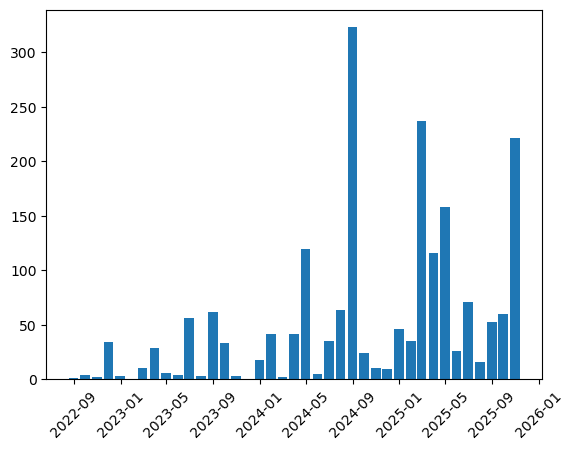

In [16]:
# grouped by on month end and output count
plt.bar(df_grouped['month_end'], df_grouped['count'], width = 25)
plt.xticks(rotation=45)   # rotate 45 degrees
plt.show()

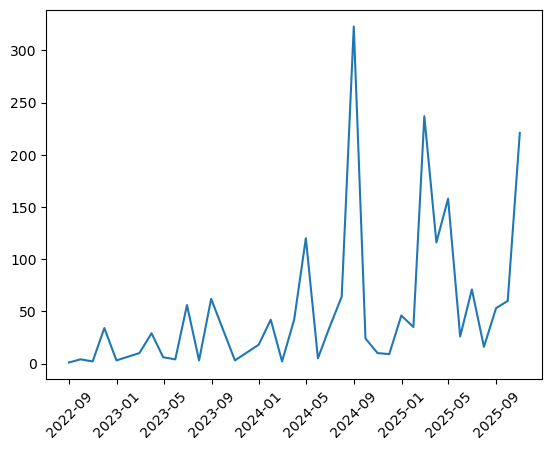

In [17]:
plt.plot(df_grouped['month_end'], df_grouped['count'], label = 'liquidation events count')
plt.xticks(rotation=45)   # rotate 45 degrees
plt.show()

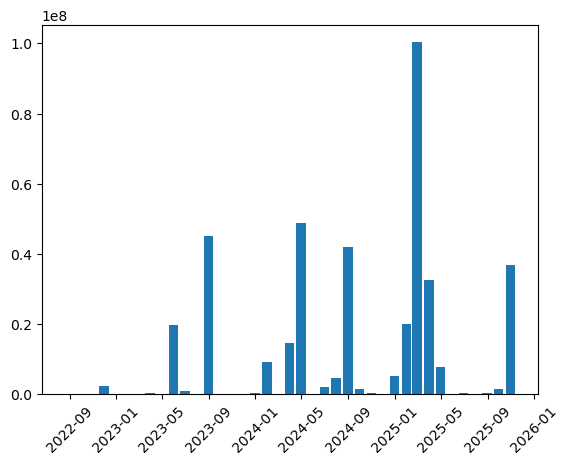

In [18]:
# grouped by on month end and output amountUSD (collateral value in usd)
df_grouped = df_liq.groupby("month_end")['amountUSD'].sum().reset_index(name="sum")
plt.bar(df_grouped['month_end'], df_grouped['sum'], width = 25)
plt.xticks(rotation=45)   # rotate 45 degrees
plt.show()

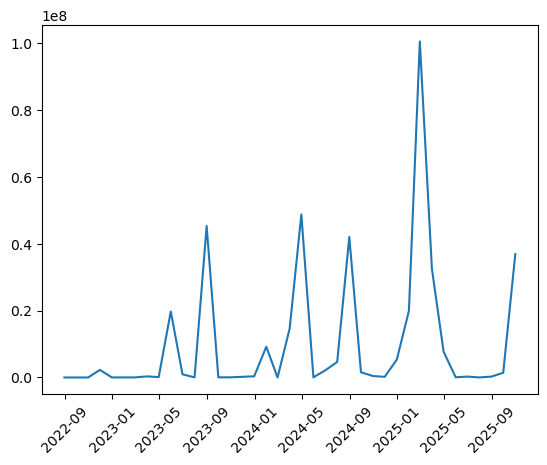

In [19]:
plt.plot(df_grouped['month_end'], df_grouped['sum'], label = 'collateral liquidated_monthly avg')
plt.xticks(rotation=45)   # rotate 45 degrees
plt.show()

In [20]:
df_grouped.sort_values(by=['sum'], ascending = False).head(10)

,month_end,sum
28,2025-02-28,1.003452e+08
18,2024-04-30,4.868719e+07
11,2023-08-31,4.523479e+07
22,2024-08-31,4.195908e+07
36,2025-10-31,3.684916e+07
29,2025-03-31,3.248527e+07
27,2025-01-31,1.989458e+07
8,2023-05-31,1.972317e+07
17,2024-03-31,1.459827e+07
15,2024-01-31,9.173679e+06


In [21]:
df_liq['month_end_str'] = df_liq["datetime_utc"].dt.strftime("%Y%m")

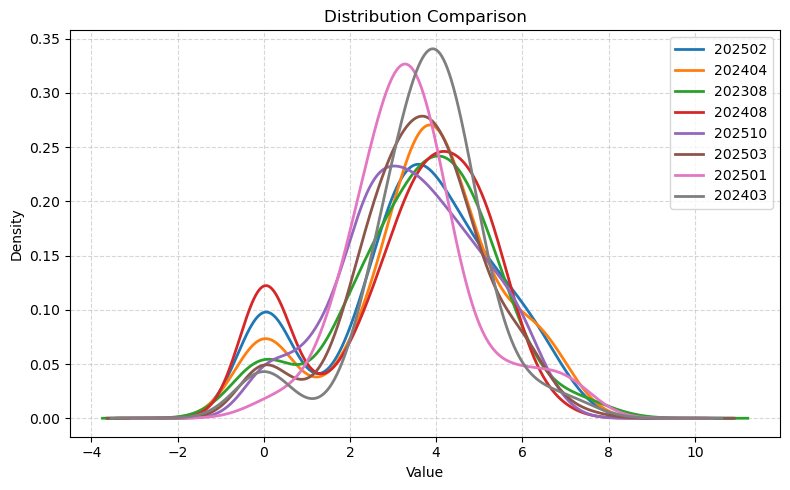

In [22]:

items = ["202502", "202404", "202308", "202408", "202510", "202503", "202501", "202403"]  # choose the columns you want to compare

plt.figure(figsize=(8, 5))
for i in items:
    x = df_liq[df_liq['month_end_str'] == i]['amountUSD'].clip(lower=1)  
    xlog = np.log10(x)
    xlog.plot(kind="kde", label=i, linewidth=2)

plt.title("Distribution Comparison")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [23]:
df_liq[df_liq['month_end_str'] == '202502'].sort_values(by=['amountUSD'], ascending = False)['amountUSD'].head(10)

921    1.774009e+07
920    1.330266e+07
893    7.033878e+06
819    6.428155e+06
867    4.732652e+06
917    4.071767e+06
919    3.917715e+06
870    3.657231e+06
748    3.221489e+06
747    2.941047e+06
Name: amountUSD, dtype: float64

In [24]:
df_main = df_liq

C:\Users\aminm\AppData\Local\Temp\ipykernel_19784\1451789099.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_main_no_outliers["quarter"] = df_main_no_outliers["datetime_utc"].dt.to_period("Q").astype(str)


<Figure size 1000x600 with 0 Axes>

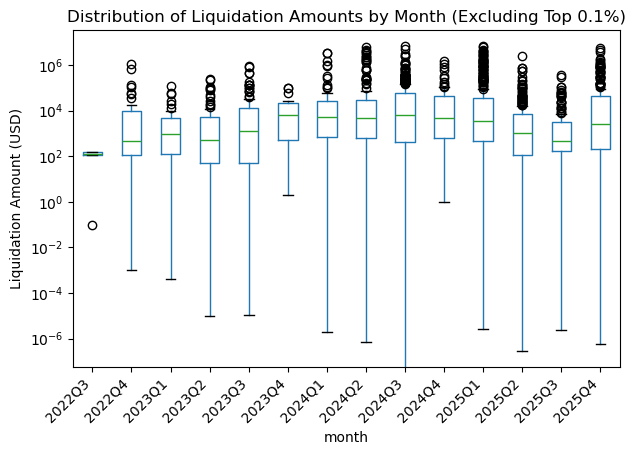

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure datetime is in datetime format
df_main["datetime_utc"] = pd.to_datetime(df_main["datetime_utc"])

# 1️⃣ Calculate the 99th percentile threshold
threshold_max = df_main["amountUSD"].quantile(0.995)
threshold_min = 1 #df_main["amountUSD"].quantile(0.001)

# 2️⃣ Filter out the top 1% (create a new dataframe)
df_main_no_outliers = df_main[(df_main["amountUSD"] <= threshold_max)].copy() #&(df_main["amountUSD"] >= threshold_min)].copy()

# 3️⃣ Create a quarterly column
df_main_no_outliers["quarter"] = df_main_no_outliers["datetime_utc"].dt.to_period("Q").astype(str)

# 4️⃣ Create the boxplot for quarters
plt.figure(figsize=(10, 6))
df_main_no_outliers.boxplot(column="amountUSD", by="quarter", grid=False, showfliers=True)

plt.title("Distribution of Liquidation Amounts by Month (Excluding Top 0.1%)")
plt.suptitle("")  # removes default title
plt.xlabel("month")
plt.ylabel("Liquidation Amount (USD)")
plt.xticks(rotation=45, ha="right")
plt.yscale("log")  # optional — if you have large variation
plt.tight_layout()
plt.show()


## Get the name of the markets

In [ ]:
query = """
{
  markets(first: 50) {
    id
    name
  }
}
"""

resp = requests.post(ENDPOINT, json={"query": query})
data = resp.json()["data"]["markets"]

df_markets = pd.json_normalize(data)
#print(df_markets)


In [27]:
df_markets.head()

,id,name
0,0x3afdc9bca9213a35503b077a6072f3d0d5ab08401570...,None
1,0x3afdc9bca9213a35503b077a6072f3d0d5ab08401808...,None
2,0x3afdc9bca9213a35503b077a6072f3d0d5ab08401f98...,Compound V3 USDT - Uniswap
3,0x3afdc9bca9213a35503b077a6072f3d0d5ab08402260...,Compound V3 USDT - Wrapped BTC
4,0x3afdc9bca9213a35503b077a6072f3d0d5ab08405149...,Compound V3 USDT - ChainLink Token


In [28]:
df_main = pd.merge(df_liq, df_markets, left_on="market_id", right_on="id", how="left")

In [29]:
df_main = df_main.rename(columns={'name': 'market_name'})

In [ ]:
# some of the markets have null values

In [30]:
df_main.loc[df_main["market_id"] == '0xc3d688b66703497daa19211eedff47f25384cdc3c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
    "market_name"] = "Compound v3 USDC – WETH"

In [31]:
df_main.loc[df_main["market_id"] == '0xc3d688b66703497daa19211eedff47f25384cdc3514910771af9ca656af840dff83e8264ecf986ca',
    "market_name"] = "Compound v3 USDC – LINK"

In [32]:
df_main.loc[df_main["market_id"] == '0xc3d688b66703497daa19211eedff47f25384cdc3c00e94cb662c3520282e6f5717214004a7f26888',
    "market_name"] = "Compound v3 USDC – COMP"

In [33]:
df_main['market_name'].unique()

array(['Compound v3 USDC – WETH', 'Compound v3 USDC – LINK',
       'Compound V3 USDT - Wrapped Ether', nan,
       'Compound V3 USDC - Wrapped BTC', 'Compound V3 USDC - Uniswap',
       'Compound V3 USDT - Wrapped BTC', 'Compound v3 USDC – COMP',
       'Compound V3 USDS - Wrapped liquid staked Ether 2.0',
       'Compound V3 USDS - Coinbase Wrapped BTC',
       'Compound V3 USDT - Compound',
       'Compound V3 USDT - ChainLink Token', 'Compound V3 USDT - Uniswap',
       'Compound V3 WETH - Wrapped liquid staked Ether 2.0', None,
       'Compound V3 USDT - Wrapped liquid staked Ether 2.0',
       'Compound V3 USDS - Wrapped Ether',
       'Compound V3 WETH - Coinbase Wrapped Staked ETH'], dtype=object)

## filter observations with null market name

In [34]:
df_main = df_main[df_main['market_name'].notnull()]

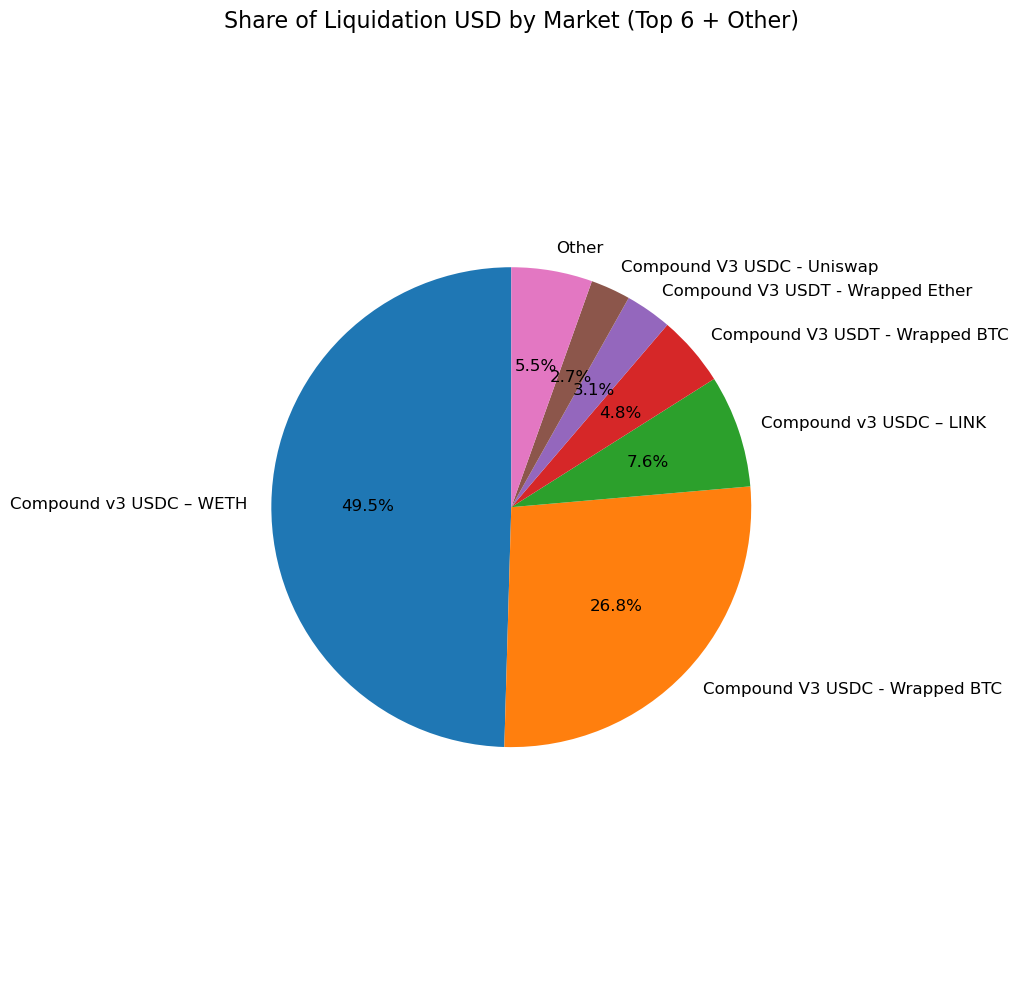

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

shares = (
    df_main.groupby("market_name")["amountUSD"]
      .sum()
      .sort_values(ascending=False)
)

# keep top 6, sum the rest as "Other"
top_n = 5
shares_top = shares.head(top_n)
shares_other = pd.Series({"Other": shares.iloc[top_n:].sum()})
shares_final = pd.concat([shares_top, shares_other])

# plotimport pandas as pd
import matplotlib.pyplot as plt

shares = df_main.groupby("market_name")["amountUSD"].sum().sort_values(ascending=False)

top_n = 6
shares_top = shares.head(top_n)
shares_other = pd.Series({"Other": shares.iloc[top_n:].sum()})
shares_final = pd.concat([shares_top, shares_other])

plt.figure(figsize=(10, 10))
plt.pie(
    shares_final.values,
    labels=shares_final.index,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 12}
)
plt.axis("equal")
plt.title("Share of Liquidation USD by Market (Top 6 + Other)", fontsize=16)
plt.tight_layout()
plt.show()


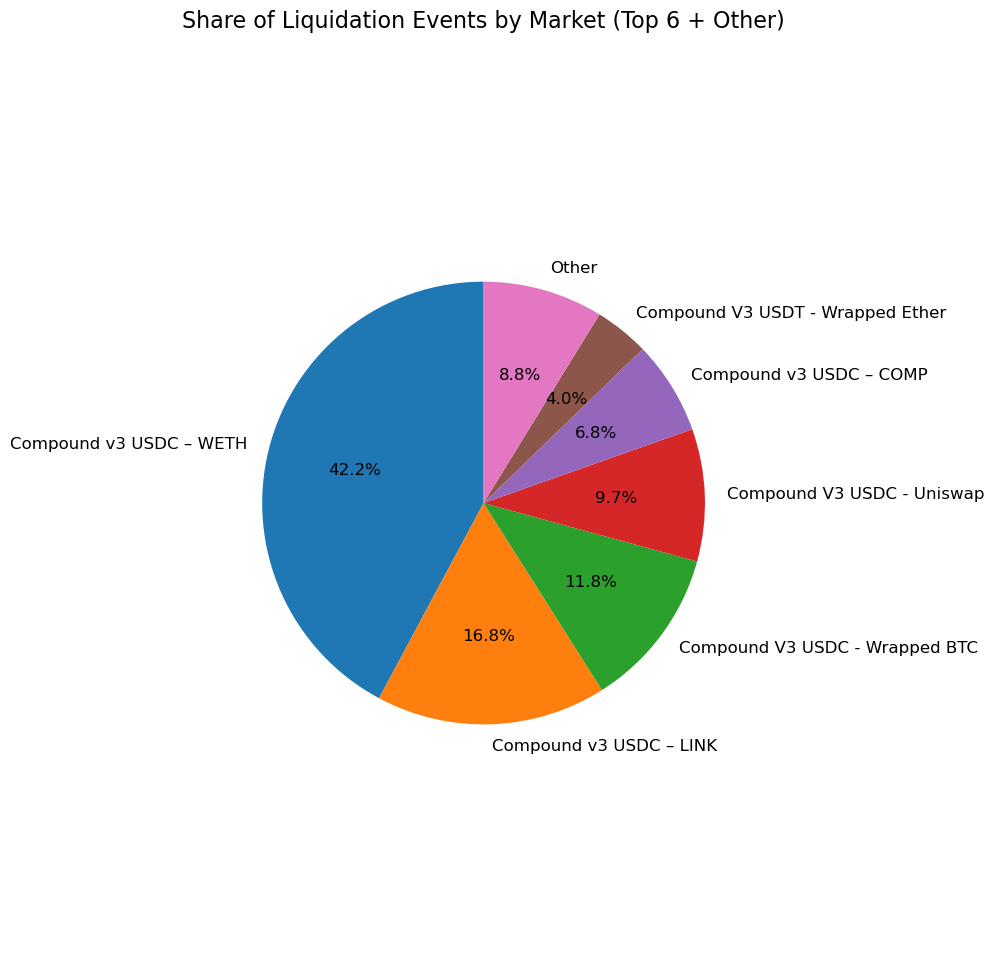

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Count number of observations per market
counts = df_main.groupby("market_name").size().sort_values(ascending=False)

# Keep top 6, group the rest as "Other"
top_n = 6
counts_top = counts.head(top_n)
counts_other = pd.Series({"Other": counts.iloc[top_n:].sum()})
counts_final = pd.concat([counts_top, counts_other])

# Plot
plt.figure(figsize=(10, 10))
plt.pie(
    counts_final.values,
    labels=counts_final.index,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 12}
)
plt.axis("equal")
plt.title("Share of Liquidation Events by Market (Top 6 + Other)", fontsize=16)
plt.tight_layout()
plt.show()


In [387]:
df_group = df_main.groupby('market_name').count()['amount'].reset_index(name = 'count')

In [389]:
pd.set_option("display.max_colwidth", None)
df_group.sort_values(by=['count'], ascending = False).reset_index(drop = True)

,market_name,count
0,Compound v3 USDC – WETH,803
1,Compound v3 USDC – LINK,320
2,Compound V3 USDC - Wrapped BTC,224
3,Compound V3 USDC - Uniswap,184
4,Compound v3 USDC – COMP,130
5,Compound V3 USDT - Wrapped Ether,76
6,Compound V3 USDT - ChainLink Token,37
7,Compound V3 USDT - Wrapped BTC,35
8,Compound V3 USDT - Compound,27
9,Compound V3 USDT - Uniswap,22


## positions data aggregations
data does not include the loan values so the positions before liqudiations should be fetched.

here the function "add_positions_before" should be run. It gets the inlut data and fetched the necessary positions basd on it

In [39]:
df_main['positions_before'] = df_main['positions_before'].apply(ast.literal_eval)

In [40]:
df_main.iloc[0]['positions_before']

[{'account': {'id': '0x538dcfa7b5a5584520571a591cc50223e800ceeb'},
  'asset': {'id': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
   'symbol': None,
   'decimals': None},
  'balance': '450154431',
  'market': {'id': '0xc3d688b66703497daa19211eedff47f25384cdc3c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'},
  'side': 'BORROWER'},
 {'account': {'id': '0x538dcfa7b5a5584520571a591cc50223e800ceeb'},
  'asset': {'id': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
   'symbol': None,
   'decimals': None},
  'balance': '136620000000000000',
  'market': {'id': '0xc3d688b66703497daa19211eedff47f25384cdc3c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'},
  'side': 'COLLATERAL'}]

In [45]:
df_main.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'amount', 'amountUSD', 'blockNumber',
       'gasLimit', 'gasPrice', 'gasUsed', 'hash', 'id_x', 'logIndex', 'nonce',
       'positions', 'profitUSD', 'timestamp', 'asset_decimals', 'asset_id',
       'asset_symbol', 'liquidatee_id', 'liquidator_id', 'market_id',
       'positions_before', 'datetime_utc', 'month_end', 'month_end_str',
       'id_y', 'market_name'],
      dtype='object')

In [46]:
df_usdc = df_main[df_main['market_name'] == 'Compound v3 USDC – WETH']

In [48]:
len(df_usdc)

803

tokens is the list of the collateral tokens in the pool.

In [53]:
tokens = []
for i in range(len(df_usdc)):
    col_list = [df_usdc.iloc[i]['positions_before'][j]['asset']['id'] for j in range(len(df_usdc.iloc[i]['positions_before']))][1:]
    tokens = tokens + col_list
    tokens = list(set(tokens))

In [54]:
tokens

['0xcbb7c0000ab88b473b1f5afd9ef808440eed33bf',
 '0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0',
 '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984',
 '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599',
 '0xc00e94cb662c3520282e6f5717214004a7f26888',
 '0x514910771af9ca656af840dff83e8264ecf986ca',
 '0x18084fba666a33d37592fa2633fd49a74dd93a88',
 '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2']

In [55]:
df_usdc.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'amount', 'amountUSD', 'blockNumber',
       'gasLimit', 'gasPrice', 'gasUsed', 'hash', 'id_x', 'logIndex', 'nonce',
       'positions', 'profitUSD', 'timestamp', 'asset_decimals', 'asset_id',
       'asset_symbol', 'liquidatee_id', 'liquidator_id', 'market_id',
       'positions_before', 'datetime_utc', 'month_end', 'month_end_str',
       'id_y', 'market_name'],
      dtype='object')

In [61]:
block_list = [i.item() for i in df_usdc['blockNumber'].unique()]

In [62]:
len(block_list)

564

In [63]:
# here is the place to run the fetch the prices using function fetch_prices_dataframe". 
# but why? in short the column amountUSD and profitUSD which are supposed to be collateral value and liquidation profit in usd respectively are incorrect.
# We treat this by getting the positions before liquidation (previous step), and use token prices at the time of liquidation to estimate the collateral value and profit of liauiation
#df_prices = fetch_prices_dataframe(RPC_URL, tokens, block_list)

In [64]:
df_prices = pd.read_csv('df_prices.csv')

In [65]:
df_prices.isnull().sum()

Unnamed: 0                                      0
block                                           0
0x514910771AF9Ca656af840dff83E8264EcF986CA      5
0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0      4
0xcbB7C0000aB88B473b1f5aFd9ef808440eed33Bf    287
0xc00e94Cb662C3520282E6f5717214004A7f26888      0
0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599      1
0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2      1
0x1f9840a85d5aF5bf1D1762F925BDADdC4201F984      0
0x18084fbA666a33d37592fA2633fD49a74DD93a88      2
dtype: int64

In [68]:
token_dict = {'0x514910771af9ca656af840dff83e8264ecf986ca': 'LINK',
 '0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0': 'wstETH',
 '0xcbb7c0000ab88b473b1f5afd9ef808440eed33bf': 'cbBTC',
 '0xc00e94cb662c3520282e6f5717214004a7f26888': 'COMP',
 '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599': 'WBTC',
 '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': 'WETH',
 '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984': 'UNI',
 '0x18084fba666a33d37592fa2633fd49a74dd93a88': 'tBTC'}

In [69]:
len(df_usdc)

803

In [70]:
df_usdc.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'amount', 'amountUSD', 'blockNumber',
       'gasLimit', 'gasPrice', 'gasUsed', 'hash', 'id_x', 'logIndex', 'nonce',
       'positions', 'profitUSD', 'timestamp', 'asset_decimals', 'asset_id',
       'asset_symbol', 'liquidatee_id', 'liquidator_id', 'market_id',
       'positions_before', 'datetime_utc', 'month_end', 'month_end_str',
       'id_y', 'market_name'],
      dtype='object')

In [71]:
token_dict

{'0x514910771af9ca656af840dff83e8264ecf986ca': 'LINK',
 '0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0': 'wstETH',
 '0xcbb7c0000ab88b473b1f5afd9ef808440eed33bf': 'cbBTC',
 '0xc00e94cb662c3520282e6f5717214004a7f26888': 'COMP',
 '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599': 'WBTC',
 '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': 'WETH',
 '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984': 'UNI',
 '0x18084fba666a33d37592fa2633fd49a74dd93a88': 'tBTC'}

In [72]:
list(token_dict.keys())

['0x514910771af9ca656af840dff83e8264ecf986ca',
 '0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0',
 '0xcbb7c0000ab88b473b1f5afd9ef808440eed33bf',
 '0xc00e94cb662c3520282e6f5717214004a7f26888',
 '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599',
 '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
 '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984',
 '0x18084fba666a33d37592fa2633fd49a74dd93a88']

In [ ]:
# this is the step we add the information we got from previous positions to the dataset.

In [ ]:
for name in list(token_dict.values()):
    df_usdc[name] = np.nan

for i in range(len(df_usdc)):
    col_list = [df_usdc.iloc[i]['positions_before'][j]['asset']['id'] for j in range(len(df_usdc.iloc[i]['positions_before']))][1:]
    for t_id in list(token_dict.keys()):
        if t_id in col_list:
            t_id_index = col_list.index(t_id)
            #df_usdc.at[i, token_dict[t_id]] = int(df_usdc.iloc[i]['positions_before'][t_id_index + 1]['balance'])
            df_usdc.iloc[i, df_usdc.columns.get_loc(token_dict[t_id])] = int(df_usdc.iloc[i]['positions_before'][t_id_index + 1]['balance'])
        else:
            #df_usdc.at[i, token_dict[t_id]] = 0
            df_usdc.iloc[i, df_usdc.columns.get_loc(token_dict[t_id])] = 0

In [76]:
df_usdc.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'amount', 'amountUSD', 'blockNumber',
       'gasLimit', 'gasPrice', 'gasUsed', 'hash', 'id_x', 'logIndex', 'nonce',
       'positions', 'profitUSD', 'timestamp', 'asset_decimals', 'asset_id',
       'asset_symbol', 'liquidatee_id', 'liquidator_id', 'market_id',
       'positions_before', 'datetime_utc', 'month_end', 'month_end_str',
       'id_y', 'market_name', 'LINK', 'wstETH', 'cbBTC', 'COMP', 'WBTC',
       'WETH', 'UNI', 'tBTC'],
      dtype='object')

In [77]:
df_prices = pd.read_csv('df_prices.csv')

In [78]:
df_prices.columns

Index(['Unnamed: 0', 'block', '0x514910771AF9Ca656af840dff83E8264EcF986CA',
       '0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0',
       '0xcbB7C0000aB88B473b1f5aFd9ef808440eed33Bf',
       '0xc00e94Cb662C3520282E6f5717214004A7f26888',
       '0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599',
       '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
       '0x1f9840a85d5aF5bf1D1762F925BDADdC4201F984',
       '0x18084fbA666a33d37592fA2633fD49a74DD93a88'],
      dtype='object')

In [79]:
len(df_prices)

564

In [ ]:
# change the column names from the token ids to token names which is much more convenient

In [81]:
token_dict_usd = {'0x514910771af9ca656af840dff83e8264ecf986ca': 'LINK_usd',
 '0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0': 'wstETH_usd',
 '0xcbb7c0000ab88b473b1f5afd9ef808440eed33bf': 'cbBTC_usd',
 '0xc00e94cb662c3520282e6f5717214004a7f26888': 'COMP_usd',
 '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599': 'WBTC_usd',
 '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': 'WETH_usd',
 '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984': 'UNI_usd',
 '0x18084fba666a33d37592fa2633fd49a74dd93a88': 'tBTC_usd'}

In [82]:
for col in df_prices.columns:
    if col.lower() in list(token_dict_usd.keys()):
        df_prices = df_prices.rename(columns = {col: token_dict_usd[col.lower()]})

In [83]:
df_prices = df_prices.rename(columns = {'block':'blockNumber'})

In [84]:
df_prices.columns

Index(['Unnamed: 0', 'blockNumber', 'LINK_usd', 'wstETH_usd', 'cbBTC_usd',
       'COMP_usd', 'WBTC_usd', 'WETH_usd', 'UNI_usd', 'tBTC_usd'],
      dtype='object')

In [85]:
df_usdc = pd.merge(df_usdc, df_prices, on='blockNumber', how='left')

In [86]:
df_usdc.columns

Index(['Unnamed: 0.1', 'Unnamed: 0_x', 'amount', 'amountUSD', 'blockNumber',
       'gasLimit', 'gasPrice', 'gasUsed', 'hash', 'id_x', 'logIndex', 'nonce',
       'positions', 'profitUSD', 'timestamp', 'asset_decimals', 'asset_id',
       'asset_symbol', 'liquidatee_id', 'liquidator_id', 'market_id',
       'positions_before', 'datetime_utc', 'month_end', 'month_end_str',
       'id_y', 'market_name', 'LINK', 'wstETH', 'cbBTC', 'COMP', 'WBTC',
       'WETH', 'UNI', 'tBTC', 'Unnamed: 0_y', 'LINK_usd', 'wstETH_usd',
       'cbBTC_usd', 'COMP_usd', 'WBTC_usd', 'WETH_usd', 'UNI_usd', 'tBTC_usd'],
      dtype='object')

In [92]:
df_usdc['cbBTC_usd'] = df_usdc['cbBTC_usd'].fillna(df_usdc['WBTC_usd'])

In [93]:
df_usdc['LINK'] = df_usdc['LINK']/1e18
df_usdc['wstETH'] = df_usdc['wstETH'] /1e18 
df_usdc['cbBTC'] = df_usdc['cbBTC']/ 1e8
df_usdc['COMP'] = df_usdc['COMP'] / 1e18
df_usdc['WBTC'] = df_usdc['WBTC'] / 1e8
df_usdc['WETH'] = df_usdc['WETH'] / 1e18
df_usdc['UNI'] = df_usdc['UNI'] / 1e18
df_usdc['tBTC'] = df_usdc['tBTC'] / 1e18

In [ ]:
# now we create the collateral column as the multiplication of token amount times token value for all the collateral tokens

In [94]:
df_usdc['collateral'] = df_usdc['LINK']*df_usdc['LINK_usd'] + df_usdc['wstETH']*df_usdc['wstETH_usd'] + df_usdc['cbBTC']*df_usdc['cbBTC_usd']\
                        +df_usdc['COMP']*df_usdc['COMP_usd'] + df_usdc['WBTC']*df_usdc['WBTC_usd'] + df_usdc['WETH']*df_usdc['WETH_usd']\
                        +df_usdc['UNI']*df_usdc['UNI_usd'] + df_usdc['tBTC']*df_usdc['tBTC_usd']

In [95]:
df_usdc['collateral'].isnull().sum()

np.int64(11)

In [96]:
nul_list = ['LINK', 'wstETH', 'cbBTC', 'COMP', 'WBTC', 'WETH', 'UNI', 'tBTC']
for el in nul_list:
    null_count = df_usdc[f"{el}_usd"].isnull().sum()
    print(el, null_count)

LINK 5
wstETH 4
cbBTC 1
COMP 0
WBTC 1
WETH 1
UNI 0
tBTC 2


In [97]:
len(df_usdc)

803

In [98]:
df_usdc = df_usdc.dropna(subset=['collateral'])

In [99]:
len(df_usdc)

792

In [100]:
df_usdc.columns

Index(['Unnamed: 0.1', 'Unnamed: 0_x', 'amount', 'amountUSD', 'blockNumber',
       'gasLimit', 'gasPrice', 'gasUsed', 'hash', 'id_x', 'logIndex', 'nonce',
       'positions', 'profitUSD', 'timestamp', 'asset_decimals', 'asset_id',
       'asset_symbol', 'liquidatee_id', 'liquidator_id', 'market_id',
       'positions_before', 'datetime_utc', 'month_end', 'month_end_str',
       'id_y', 'market_name', 'LINK', 'wstETH', 'cbBTC', 'COMP', 'WBTC',
       'WETH', 'UNI', 'tBTC', 'Unnamed: 0_y', 'LINK_usd', 'wstETH_usd',
       'cbBTC_usd', 'COMP_usd', 'WBTC_usd', 'WETH_usd', 'UNI_usd', 'tBTC_usd',
       'collateral'],
      dtype='object')

In [ ]:
# get the loan value based on positions_before column

In [104]:
df_usdc['LOAN'] = df_usdc['positions_before'].apply(lambda x: int(x[0]['balance'])/1e6)

C:\Users\aminm\AppData\Local\Temp\ipykernel_19784\1890607522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usdc['LOAN'] = df_usdc['positions_before'].apply(lambda x: int(x[0]['balance'])/1e6)


In [105]:
# calculate LTV
df_usdc['LTV'] = df_usdc['LOAN']/df_usdc['collateral']

C:\Users\aminm\AppData\Local\Temp\ipykernel_19784\2595334659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usdc['LTV'] = df_usdc['LOAN']/df_usdc['collateral']


In [106]:
df_usdc['LTV'].describe()

count    792.000000
mean       0.900634
std        0.071047
min        0.695405
25%        0.872662
50%        0.894900
75%        0.906893
max        1.369629
Name: LTV, dtype: float64

In [107]:
df_usdc['collateral_count'] = df_usdc['positions_before'].apply(lambda x: len(x)-1)

C:\Users\aminm\AppData\Local\Temp\ipykernel_19784\3998136916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usdc['collateral_count'] = df_usdc['positions_before'].apply(lambda x: len(x)-1)


In [108]:
df_usdc['collateral_count'].unique()

array([1, 2, 3, 4, 5, 6])

In [109]:
df_usdc.groupby('collateral_count')['LTV'].mean()

collateral_count
1    0.927186
2    0.869709
3    0.840328
4    0.841676
5    0.846093
6    0.851640
Name: LTV, dtype: float64

In [110]:
df_usdc['profit_perc'] = df_usdc['profitUSD']/df_usdc['collateral']

C:\Users\aminm\AppData\Local\Temp\ipykernel_19784\3025779759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usdc['profit_perc'] = df_usdc['profitUSD']/df_usdc['collateral']


In [111]:
df_usdc['profit_perc'].describe()

count    7.920000e+02
mean     4.104888e-02
std      1.656581e-02
min      6.004444e-14
25%      3.285262e-02
50%      4.995503e-02
75%      5.000000e-02
max      7.000018e-02
Name: profit_perc, dtype: float64

In [112]:
df_usdc.groupby('collateral_count')['profit_perc'].mean()

collateral_count
1    0.050894
2    0.027812
3    0.021265
4    0.022373
5    0.019873
6    0.013017
Name: profit_perc, dtype: float64

In [113]:
df_usdc[df_usdc['collateral_count'] == 1]['profit_perc'].describe()

count    495.000000
mean       0.050894
std        0.004361
min        0.047680
25%        0.049994
50%        0.050000
75%        0.050000
max        0.070000
Name: profit_perc, dtype: float64

In [114]:
from scipy import stats
df_usdc_1 = df_usdc[df_usdc['collateral_count'] == 1]
thres = df_usdc_1['profit_perc'].quantile(0.95)
t_stat, p_value = stats.ttest_1samp(df_usdc_1[df_usdc_1['profit_perc']<thres]['profit_perc'], 0.05)
print(p_value)

1.979023827857388e-19


In [115]:
df_usdc["profit_USD"] = np.where(df_usdc['collateral_count'] != 1, df_usdc['collateral']*0.05 , df_usdc["profitUSD"])

C:\Users\aminm\AppData\Local\Temp\ipykernel_19784\316781653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usdc["profit_USD"] = np.where(df_usdc['collateral_count'] != 1, df_usdc['collateral']*0.05 , df_usdc["profitUSD"])


In [116]:
df_usdc.groupby('collateral_count')['LTV'].mean()

collateral_count
1    0.927186
2    0.869709
3    0.840328
4    0.841676
5    0.846093
6    0.851640
Name: LTV, dtype: float64

<Axes: >

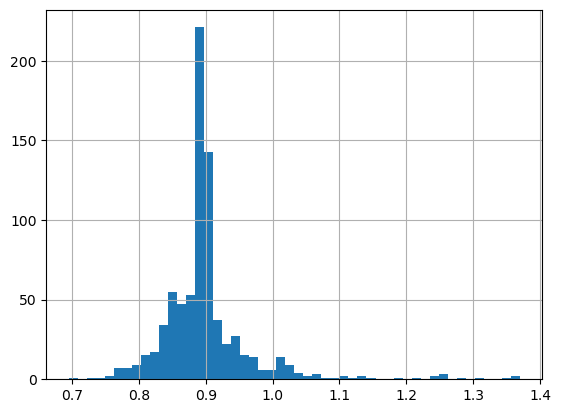

In [117]:
df_usdc['LTV'].hist(bins = 50)

In [123]:
df_usdc['date'] = df_usdc['datetime_utc'].dt.date

C:\Users\aminm\AppData\Local\Temp\ipykernel_19784\3464603917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usdc['date'] = df_usdc['datetime_utc'].dt.date


In [124]:
df_usdc['date'].head(2)

0    2025-10-30
1    2025-10-30
Name: date, dtype: object

## create percentage change in weth price

In [125]:
df_usdc['WETH_change'] = df_usdc['WETH_usd'].pct_change()

C:\Users\aminm\AppData\Local\Temp\ipykernel_19784\3746530208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usdc['WETH_change'] = df_usdc['WETH_usd'].pct_change()


In [126]:
df_usdc['WETH_change'].isnull().sum()

np.int64(1)

In [127]:
df_usdc = df_usdc.dropna(subset=['WETH_change'])

In [128]:
len(df_usdc)

791

In [129]:
agg_column = 'date'
df_usdc_agg = df_usdc.groupby('date', as_index = False).agg({
    'collateral': ['count'],
    'collateral': ['sum', 'mean'],
    'LTV': ['mean'],
    'WETH_usd': ['mean'],
    'WETH_change': ['mean']
})

In [130]:
df_usdc_agg.head(5)

date  collateral                   LTV     WETH_usd WETH_change
                      sum        mean      mean         mean        mean
0  2022-08-27  111.718688  111.718688  0.895189  1489.582500   -0.057761
1  2022-09-13  158.089625  158.089625  0.899284  1580.896248    0.088497
2  2022-09-16  145.236613  145.236613  0.895261  1452.366127    0.120982
3  2022-09-22  129.656580   64.828290  0.941299  1295.620000   -0.087906
4  2022-10-31  394.282710  394.282710  0.746530  1571.994650    0.041055

In [131]:
df_usdc_agg.columns

MultiIndex([(       'date',     ''),
            ( 'collateral',  'sum'),
            ( 'collateral', 'mean'),
            (        'LTV', 'mean'),
            (   'WETH_usd', 'mean'),
            ('WETH_change', 'mean')],
           )

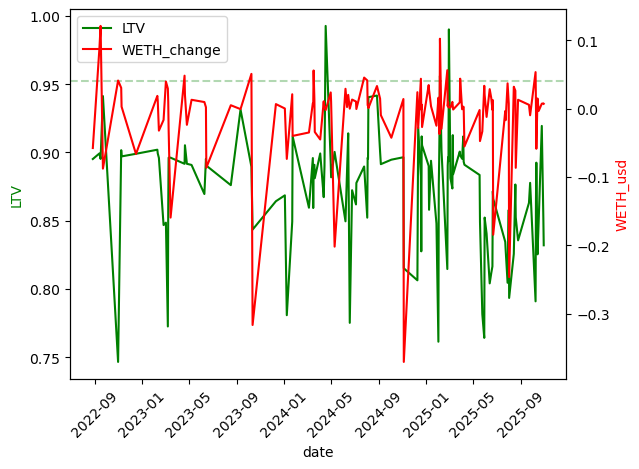

In [132]:
df_usdc = df_usdc.sort_values(by=[agg_column])
figure, ax = plt.subplots()
lns1 = ax.plot(df_usdc_agg[agg_column], df_usdc_agg['LTV']['mean'], color = 'green',  label = 'LTV' )
lns2 = plt.axhline(0.9523, color = 'green', alpha = 0.3, linestyle = '--', label = 'liquidation multiplier')
ax.set_ylabel('LTV', color = 'green')
ax.set_xlabel('date')
plt.xticks(rotation=45)
ax2 = ax.twinx()
#lns3 = ax2.plot(df_usdc_agg[agg_column], df_usdc_agg['collateral']['sum'], color = 'red',  label = 'collateral' )
#ax2.set_ylabel('collateral_sum', color = 'red')
#lns3 = ax2.plot(df_usdc_agg[agg_column], df_usdc_agg['WETH_usd']['mean'], color = 'red',  label = 'WETH_usd' )
lns3 = ax2.plot(df_usdc_agg[agg_column], df_usdc_agg['WETH_change']['mean'], color = 'red',  label = 'WETH_change' )
ax2.set_ylabel('WETH_usd', color = 'red')
lns = lns1+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=2)
plt.show()

In [137]:
start_date = pd.Timestamp('2024-12-01')
end_date = pd.Timestamp('2025-05-31')

df_usdc_agg_fil = df_usdc_agg[(df_usdc_agg['date'] <= end_date.date())&(df_usdc_agg['date'] >= start_date.date())]

In [138]:
len(df_usdc_agg_fil)

36

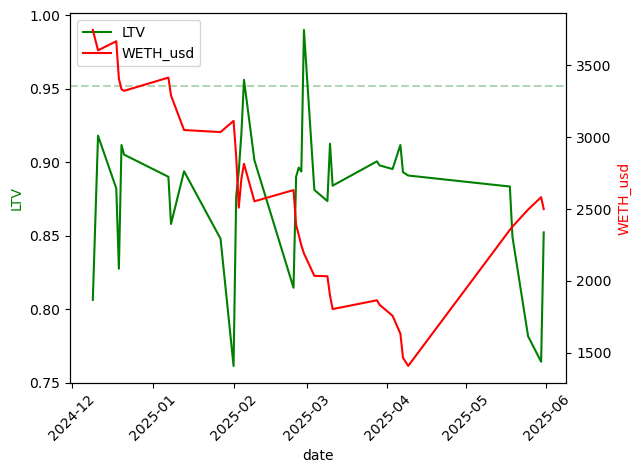

In [139]:
df_usdc_agg_fil = df_usdc_agg_fil.sort_values(by=[agg_column])
figure, ax = plt.subplots()
lns1 = ax.plot(df_usdc_agg_fil[agg_column], df_usdc_agg_fil['LTV']['mean'], color = 'green',  label = 'LTV' )
lns2 = plt.axhline(0.9523, color = 'green', alpha = 0.3, linestyle = '--', label = 'liquidation multiplier')
ax.set_ylabel('LTV', color = 'green')
ax.set_xlabel('date')
plt.xticks(rotation=45)
ax2 = ax.twinx()
#lns3 = ax2.plot(df_usdc_agg[agg_column], df_usdc_agg['collateral']['sum'], color = 'red',  label = 'collateral' )
#ax2.set_ylabel('collateral_sum', color = 'red')
lns3 = ax2.plot(df_usdc_agg_fil[agg_column], df_usdc_agg_fil['WETH_usd']['mean'], color = 'red',  label = 'WETH_usd' )
ax2.set_ylabel('WETH_usd', color = 'red')
lns = lns1+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=2)
plt.show()

## calculate correlation

In [140]:
corr = df_usdc['LTV'].corr(df_usdc['WETH_usd'])
print(corr)

-0.15591050749054405


In [141]:
corr = df_usdc['LTV'].corr(df_usdc['WETH_change'])
print(corr)

0.0014019796758825127


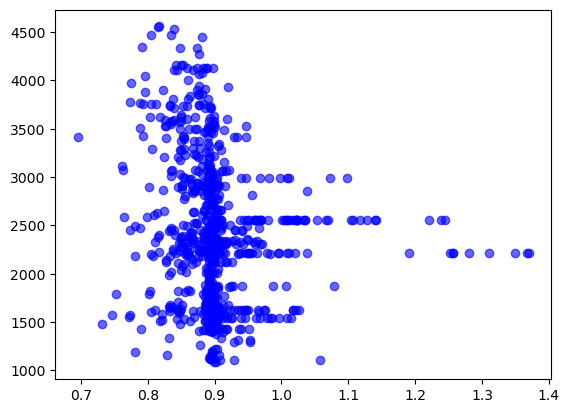

In [142]:
plt.scatter(df_usdc['LTV'], df_usdc['WETH_usd'], alpha=0.6, color = 'blue')
import seaborn as sns
#sns.regplot(x='WETH_usd', y='LTV', data=df_usdc, color = 'red')

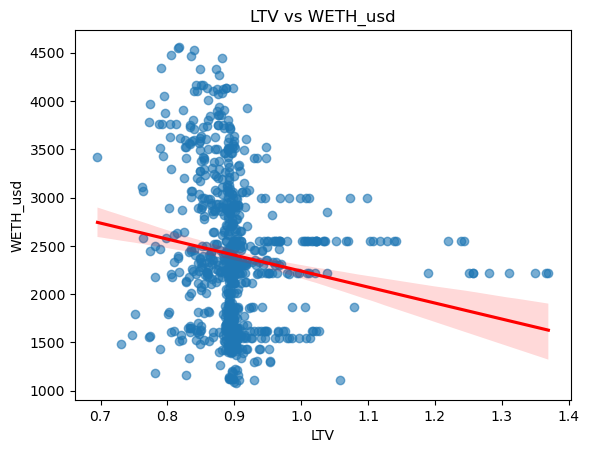

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(
    x='LTV',
    y='WETH_usd',
    data=df_usdc,
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)

plt.title('LTV vs WETH_usd')
plt.show()

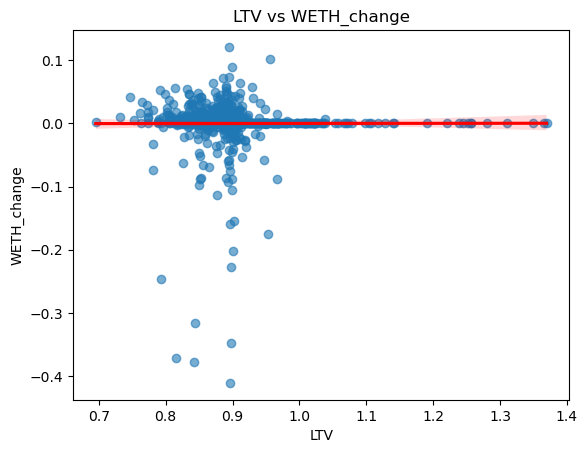

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(
    x='LTV',
    y='WETH_change',
    data=df_usdc,
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)

plt.title('LTV vs WETH_change')
plt.show()

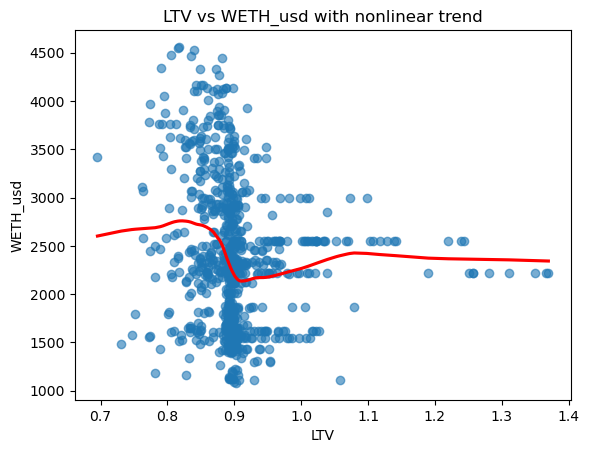

In [145]:
sns.regplot(
    x='LTV',
    y='WETH_usd',
    data=df_usdc,
    lowess=True,       # smooth nonlinear trend
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title('LTV vs WETH_usd with nonlinear trend')
plt.show()


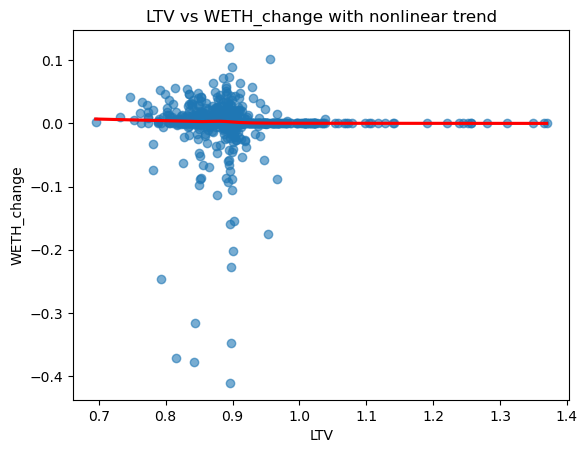

In [146]:
sns.regplot(
    x='LTV',
    y='WETH_change',
    data=df_usdc,
    lowess=True,       # smooth nonlinear trend
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title('LTV vs WETH_change with nonlinear trend')
plt.show()


## Bad debt analysis

In [147]:
df_usdc.columns

Index(['Unnamed: 0.1', 'Unnamed: 0_x', 'amount', 'amountUSD', 'blockNumber',
       'gasLimit', 'gasPrice', 'gasUsed', 'hash', 'id_x', 'logIndex', 'nonce',
       'positions', 'profitUSD', 'timestamp', 'asset_decimals', 'asset_id',
       'asset_symbol', 'liquidatee_id', 'liquidator_id', 'market_id',
       'positions_before', 'datetime_utc', 'month_end', 'month_end_str',
       'id_y', 'market_name', 'LINK', 'wstETH', 'cbBTC', 'COMP', 'WBTC',
       'WETH', 'UNI', 'tBTC', 'Unnamed: 0_y', 'LINK_usd', 'wstETH_usd',
       'cbBTC_usd', 'COMP_usd', 'WBTC_usd', 'WETH_usd', 'UNI_usd', 'tBTC_usd',
       'collateral', 'LOAN', 'LTV', 'collateral_count', 'profit_perc',
       'profit_USD', 'date', 'WETH_change'],
      dtype='object')

In [151]:
df_usdc[['gasPrice', 'gasUsed', 'WETH_usd']]

,gasPrice,gasUsed,WETH_usd
802,10130170075,539020,1489.582500
801,32717690281,488116,1580.896248
800,9845700947,487698,1452.366127
799,3492757916,468643,1295.620000
798,4277252730,487832,1295.620000
...,...,...,...
5,2946281913,407589,3857.194849
4,1029076906,923511,3842.412008
3,17859669480,424247,3756.940000
2,4063267792,1649932,3756.940000


In [ ]:
# create column "tx_cost_usd" as the gas fee paid in usd

In [152]:
WEI_PER_ETH = 1e18
df_usdc['tx_cost_eth'] = df_usdc['gasPrice'] * df_usdc['gasUsed'] / WEI_PER_ETH
df_usdc['tx_cost_usd'] = df_usdc['tx_cost_eth'] * df_usdc['WETH_usd']

In [153]:
df_usdc['tx_cost_usd'].describe()

count     791.000000
mean      119.241993
std       433.961253
min     -8975.826265
25%         8.325867
50%        35.939414
75%       152.016600
max      3868.410281
Name: tx_cost_usd, dtype: float64

In [155]:
df_usdc = df_usdc[df_usdc['tx_cost_usd']>0]

In [156]:
len(df_usdc)

790

In [157]:
df_usdc['tx_cost_usd'].describe()

count     790.000000
mean      130.754738
std       289.113184
min         0.211003
25%         8.388904
50%        35.939414
75%       152.738964
max      3868.410281
Name: tx_cost_usd, dtype: float64

In [158]:
df_usdc.sort_values(by=['tx_cost_usd'], ascending = False)['tx_cost_usd'].head(10)

32     3868.410281
27     2572.272757
26     2572.272757
336    2408.047732
38     2197.883073
96     2121.740068
30     2090.786117
333    1408.317306
16     1337.157884
343    1121.934131
Name: tx_cost_usd, dtype: float64

In [159]:
df_usdc.columns

Index(['Unnamed: 0.1', 'Unnamed: 0_x', 'amount', 'amountUSD', 'blockNumber',
       'gasLimit', 'gasPrice', 'gasUsed', 'hash', 'id_x', 'logIndex', 'nonce',
       'positions', 'profitUSD', 'timestamp', 'asset_decimals', 'asset_id',
       'asset_symbol', 'liquidatee_id', 'liquidator_id', 'market_id',
       'positions_before', 'datetime_utc', 'month_end', 'month_end_str',
       'id_y', 'market_name', 'LINK', 'wstETH', 'cbBTC', 'COMP', 'WBTC',
       'WETH', 'UNI', 'tBTC', 'Unnamed: 0_y', 'LINK_usd', 'wstETH_usd',
       'cbBTC_usd', 'COMP_usd', 'WBTC_usd', 'WETH_usd', 'UNI_usd', 'tBTC_usd',
       'collateral', 'LOAN', 'LTV', 'collateral_count', 'profit_perc',
       'profit_USD', 'date', 'WETH_change', 'tx_cost_eth', 'tx_cost_usd'],
      dtype='object')

In [182]:
df_usdc['market_id'].unique()

array(['0xc3d688b66703497daa19211eedff47f25384cdc3c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'],
      dtype=object)

In [184]:
market_address = '0xc3d688B66703497DAA19211EEdff47f25384cdc3'


In [ ]:
# next we run "get_comet_params_by_blocks" to get the necessary params to estimate collateral discount and liquidators profit

In [238]:
ASSETS = {
    "LINK":  "0x514910771AF9Ca656af840dff83E8264EcF986CA",
    "wstETH":"0x7f39c581f595b53c5cb5bb7d1409e5c3f6b7c53f",
    "cbBTC": "0xcbb7c0000ab88b473b1f5afd9ef808440eed33bf",
    "COMP":  "0xc00e94cb662c3520282e6f5717214004a7f26888",
    "WBTC":  "0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599",
    "WETH":  "0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2",
    "UNI":   "0x1f9840a85d5aF5bf1D1762F925BDADdC4201F984",
    "tBTC":  "0x18084fba666a33d37592fa2633fd49a74dd93a88",
}

In [242]:
df_latest = get_comet_params_by_blocks(RPC_URL, market_address, block_list, ASSETS, debug = False)

In [246]:
df_latest.to_csv('params.csv')

In [245]:
df_latest.isnull().sum()

block                       0
asset                       0
listed_at_block             0
storeFrontPriceFactor       0
liquidationFactor         569
discountFactor            569
note                     3288
dtype: int64

In [249]:
df_latest[df_latest["discountFactor"].isna()]['asset'].unique()

array(['cbBTC', 'tBTC'], dtype=object)

In [250]:
df_latest.head(10)

,block,asset,listed_at_block,storeFrontPriceFactor,liquidationFactor,discountFactor,note
0,15419043,LINK,False,0.5,0.790,0.1050,None
1,15419043,wstETH,False,0.5,0.825,0.0875,set equal to WETH
2,15419043,cbBTC,False,0.5,NaN,NaN,not listed at block
3,15419043,COMP,False,0.5,0.650,0.1750,None
4,15419043,WBTC,False,0.5,0.700,0.1500,None
5,15419043,WETH,False,0.5,0.825,0.0875,None
6,15419043,UNI,False,0.5,0.750,0.1250,None
7,15419043,tBTC,False,0.5,NaN,NaN,not listed at block
8,15527516,LINK,False,0.5,0.790,0.1050,None
9,15527516,wstETH,False,0.5,0.825,0.0875,set equal to WETH


In [253]:
# Pivot and reshape
df_pivot = (
    df_latest.drop(columns=["note", "discountFactor"])  # remove unnecessary columns
      .pivot(
          index="block",
          columns="asset",
          values="liquidationFactor"
      )
      .reset_index()
)

# Add back storeFrontPriceFactor (same for all rows of same block)
store_front = df_latest[["block", "storeFrontPriceFactor"]].drop_duplicates()
df_final = pd.merge(store_front, df_pivot, on="block", how="left")

# Rename for clarity
df_final = df_final.rename(columns={
    "block": "blockNumber",
    "storeFrontPriceFactor": "store_front_pricefactor"
})

# Rename asset columns to {token_name}_lf
df_final.columns = [
    f"{col}_lf" if col not in ["blockNumber", "store_front_pricefactor"] else col
    for col in df_final.columns
]

df_final.head(10)


,blockNumber,store_front_pricefactor,COMP_lf,LINK_lf,UNI_lf,WBTC_lf,WETH_lf,cbBTC_lf,tBTC_lf,wstETH_lf
0,15419043,0.5,0.65,0.79,0.75,0.7,0.825,NaN,NaN,0.825
1,15527516,0.5,0.65,0.79,0.75,0.7,0.825,NaN,NaN,0.825
2,15542593,0.5,0.65,0.79,0.75,0.7,0.825,NaN,NaN,0.825
3,15588620,0.5,0.65,0.79,0.75,0.7,0.825,NaN,NaN,0.825
4,15588622,0.5,0.65,0.79,0.75,0.7,0.825,NaN,NaN,0.825
5,15868513,0.5,0.65,0.79,0.75,0.7,0.825,NaN,NaN,0.825
6,15927502,0.5,0.65,0.79,0.75,0.7,0.825,NaN,NaN,0.825
7,15927472,0.5,0.65,0.79,0.75,0.7,0.825,NaN,NaN,0.825
8,15927505,0.5,0.65,0.79,0.75,0.7,0.825,NaN,NaN,0.825
9,15927047,0.5,0.65,0.79,0.75,0.7,0.825,NaN,NaN,0.825


In [254]:
df_final['cbBTC_lf'] = df_final['WBTC_lf']
df_final['tBTC_lf'] = df_final['WBTC_lf']
df_final.head(10)

,blockNumber,store_front_pricefactor,COMP_lf,LINK_lf,UNI_lf,WBTC_lf,WETH_lf,cbBTC_lf,tBTC_lf,wstETH_lf
0,15419043,0.5,0.65,0.79,0.75,0.7,0.825,0.7,0.7,0.825
1,15527516,0.5,0.65,0.79,0.75,0.7,0.825,0.7,0.7,0.825
2,15542593,0.5,0.65,0.79,0.75,0.7,0.825,0.7,0.7,0.825
3,15588620,0.5,0.65,0.79,0.75,0.7,0.825,0.7,0.7,0.825
4,15588622,0.5,0.65,0.79,0.75,0.7,0.825,0.7,0.7,0.825
5,15868513,0.5,0.65,0.79,0.75,0.7,0.825,0.7,0.7,0.825
6,15927502,0.5,0.65,0.79,0.75,0.7,0.825,0.7,0.7,0.825
7,15927472,0.5,0.65,0.79,0.75,0.7,0.825,0.7,0.7,0.825
8,15927505,0.5,0.65,0.79,0.75,0.7,0.825,0.7,0.7,0.825
9,15927047,0.5,0.65,0.79,0.75,0.7,0.825,0.7,0.7,0.825


In [256]:
df_usdc_p = pd.merge(df_usdc, df_final, on="blockNumber", how="left")

In [259]:
df_usdc_p['1'] = 1

In [260]:
df_usdc_p.columns

Index(['Unnamed: 0.1', 'Unnamed: 0_x', 'amount', 'amountUSD', 'blockNumber',
       'gasLimit', 'gasPrice', 'gasUsed', 'hash', 'id_x', 'logIndex', 'nonce',
       'positions', 'profitUSD', 'timestamp', 'asset_decimals', 'asset_id',
       'asset_symbol', 'liquidatee_id', 'liquidator_id', 'market_id',
       'positions_before', 'datetime_utc', 'month_end', 'month_end_str',
       'id_y', 'market_name', 'LINK', 'wstETH', 'cbBTC', 'COMP', 'WBTC',
       'WETH', 'UNI', 'tBTC', 'Unnamed: 0_y', 'LINK_usd', 'wstETH_usd',
       'cbBTC_usd', 'COMP_usd', 'WBTC_usd', 'WETH_usd', 'UNI_usd', 'tBTC_usd',
       'collateral', 'LOAN', 'LTV', 'collateral_count', 'profit_perc',
       'profit_USD', 'date', 'WETH_change', 'tx_cost_eth', 'tx_cost_usd',
       'bad_loan', 'store_front_pricefactor', 'COMP_lf', 'LINK_lf', 'UNI_lf',
       'WBTC_lf', 'WETH_lf', 'cbBTC_lf', 'tBTC_lf', 'wstETH_lf', '1'],
      dtype='object')

In [258]:
df_usdc = df_usdc_p

In [ ]:
df_usdc

In [ ]:
'LINK_usd', 'wstETH_usd', 'cbBTC_usd', 'COMP_usd', 'WBTC_usd', 'WETH_usd', 'UNI_usd', 'tBTC_usd'

In [1]:
# calculating collateral discount as 
# amount token * token price * store_front_pricefactor * (1 - token liquidity factor)

In [265]:
df_usdc['collateral_discount'] = df_usdc['LINK']*df_usdc['LINK_usd']*df_usdc['store_front_pricefactor']*(df_usdc['1'] - df_usdc['LINK_lf'])\
+df_usdc['wstETH']*df_usdc['wstETH_usd']*df_usdc['store_front_pricefactor']*(df_usdc['1'] - df_usdc['wstETH_lf'])\
+df_usdc['cbBTC']*df_usdc['cbBTC_usd']*df_usdc['store_front_pricefactor']*(df_usdc['1'] - df_usdc['cbBTC_lf'])\
+df_usdc['COMP']*df_usdc['COMP_usd']*df_usdc['store_front_pricefactor']*(df_usdc['1'] - df_usdc['COMP_lf'])\
+df_usdc['WBTC']*df_usdc['WBTC_usd']*df_usdc['store_front_pricefactor']*(df_usdc['1'] - df_usdc['WBTC_lf'])\
+df_usdc['WETH']*df_usdc['WETH_usd']*df_usdc['store_front_pricefactor']*(df_usdc['1'] - df_usdc['WETH_lf'])\
+df_usdc['UNI']*df_usdc['UNI_usd']*df_usdc['store_front_pricefactor']*(df_usdc['1'] - df_usdc['UNI_lf'])\
+df_usdc['tBTC']*df_usdc['tBTC_usd']*df_usdc['store_front_pricefactor']*(df_usdc['1'] - df_usdc['tBTC_lf'])

In [266]:
df_usdc[df_usdc['collateral_count'] == 1][['collateral', 'profitUSD', 'collateral_discount']]

,collateral,profitUSD,collateral_discount
0,111.718688,5.585934,9.775385
1,158.089625,7.904481,13.832842
2,145.236613,7.261831,12.708204
3,129.562000,6.478100,11.336675
4,0.094580,0.004729,0.008276
...,...,...,...
778,1503.958302,104.624115,157.915622
781,1374.752598,95.631576,144.349023
782,809.330400,56.299251,84.979692
783,1.664507,0.116516,0.174773


In [268]:
(df_usdc['collateral_discount']/df_usdc['collateral']).mean()

np.float64(0.11214702927506012)

In [ ]:
# calculate net profit of the liquidators

In [269]:
df_usdc['liq_net_profit_usd'] = df_usdc['collateral_discount'] - df_usdc['tx_cost_usd']

In [278]:
df_usdc.sort_values(by=['liq_net_profit_usd'], ascending = False)[['liq_net_profit_usd','collateral', 'collateral_discount', 'tx_cost_usd']].head(10)

,liq_net_profit_usd,collateral,collateral_discount,tx_cost_usd
463,3.961663e+06,3.517009e+07,3.961722e+06,59.289075
88,3.298582e+06,3.099116e+07,3.299041e+06,459.251281
583,2.023608e+06,1.927249e+07,2.023612e+06,3.494176
185,1.622464e+06,1.402528e+07,1.623100e+06,635.803417
157,1.282948e+06,1.221988e+07,1.283087e+06,138.504139
429,1.193595e+06,1.136765e+07,1.193603e+06,8.121775
90,1.116100e+06,1.063451e+07,1.116623e+06,523.688218
472,7.936632e+05,7.494526e+06,7.938349e+05,171.786945
430,7.653346e+05,7.289001e+06,7.653451e+05,10.500300
521,7.003747e+05,6.207828e+06,7.003991e+05,24.380123


In [279]:
df_usdc.sort_values(by=['liq_net_profit_usd'])[['liq_net_profit_usd','collateral', 'collateral_discount', 'tx_cost_usd']].head(10)

,liq_net_profit_usd,collateral,collateral_discount,tx_cost_usd
764,-3626.494996,2303.955097,241.915285,3868.410281
762,-2470.932417,722.926588,101.340339,2572.272757
770,-2132.142224,573.704465,65.740849,2197.883073
763,-1635.956637,4331.709329,454.829480,2090.786117
745,-888.201412,28.822439,3.026356,891.227768
91,-579.196235,0.018288,0.001920,579.198155
699,-562.773804,449.985882,68.558995,631.332799
190,-445.347303,1332.115482,139.872126,585.219428
134,-422.895282,1477.880444,155.177447,578.072729
191,-347.381470,2265.123417,237.837959,585.219428


In [283]:
df_usdc[df_usdc['liq_net_profit_usd']<0]['tx_cost_usd'].describe()

count     217.000000
mean      163.114720
std       384.463190
min         0.211003
25%        13.963700
50%        51.628147
75%       274.916185
max      3868.410281
Name: tx_cost_usd, dtype: float64

In [284]:
df_usdc[df_usdc['liq_net_profit_usd']> 0]['tx_cost_usd'].describe()

count     573.000000
mean      118.499736
std       242.758852
min         0.344421
25%         7.706705
50%        29.693601
75%       136.002233
max      2572.272757
Name: tx_cost_usd, dtype: float64

In [272]:
len(df_usdc)

790

In [285]:
len(df_usdc[df_usdc['liq_net_profit_usd']<-45])

103

In [270]:
agg_column = 'date'
df_usdc_agg = df_usdc.groupby('date', as_index = False).agg({
    'collateral_discount': ['count'],
    'collateral_discount': ['mean'],
    'liq_net_profit_usd': ['mean'],
    'WETH_usd': ['mean']
})

In [271]:
df_usdc_agg.head(5)

,date,collateral_discount,liq_net_profit_usd,WETH_usd
,,mean,mean,mean
0,2022-08-27,9.775385,1.641722,1489.582500
1,2022-09-13,13.832842,-11.414115,1580.896248
2,2022-09-16,12.708204,5.734336,1452.366127
3,2022-09-22,5.672475,3.260395,1295.620000
4,2022-10-31,61.021601,42.428320,1571.994650


In [274]:
df_usdc_agg.columns

MultiIndex([(               'date',     ''),
            ('collateral_discount', 'mean'),
            ( 'liq_net_profit_usd', 'mean'),
            (           'WETH_usd', 'mean')],
           )

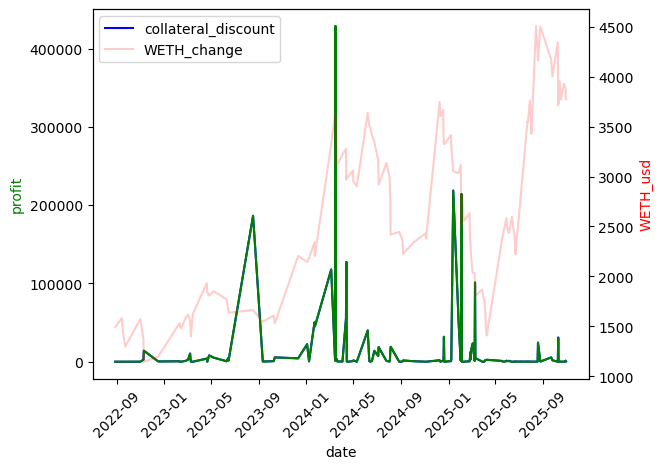

In [280]:
df_usdc = df_usdc.sort_values(by=[agg_column])
figure, ax = plt.subplots()
lns1 = ax.plot(df_usdc_agg[agg_column], df_usdc_agg['collateral_discount']['mean'], color = 'blue',  label = 'collateral_discount' )
lns2 = ax.plot(df_usdc_agg[agg_column], df_usdc_agg['liq_net_profit_usd']['mean'], color = 'green',  label = 'net_profit' )
#lns2 = plt.axhline(0.9523, color = 'green', alpha = 0.3, linestyle = '--', label = 'liquidation multiplier')
ax.set_ylabel('profit', color = 'green')
ax.set_xlabel('date')
plt.xticks(rotation=45)
ax2 = ax.twinx()
#lns3 = ax2.plot(df_usdc_agg[agg_column], df_usdc_agg['collateral']['sum'], color = 'red',  label = 'collateral' )
#ax2.set_ylabel('collateral_sum', color = 'red')
#lns3 = ax2.plot(df_usdc_agg[agg_column], df_usdc_agg['WETH_usd']['mean'], color = 'red',  label = 'WETH_usd' )
lns3 = ax2.plot(df_usdc_agg[agg_column], df_usdc_agg['WETH_usd']['mean'], color = 'red',alpha = 0.2,  label = 'WETH_change' )
ax2.set_ylabel('WETH_usd', color = 'red')
lns = lns1+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=2)
plt.show()

In [287]:
df_usdc['remaining'] = df_usdc['collateral'] - df_usdc['LOAN'] - 0.05*df_usdc['collateral']

In [289]:
len(df_usdc[df_usdc['remaining'] <0])

96

In [293]:
df_usdc.columns

Index(['Unnamed: 0.1', 'Unnamed: 0_x', 'amount', 'amountUSD', 'blockNumber',
       'gasLimit', 'gasPrice', 'gasUsed', 'hash', 'id_x', 'logIndex', 'nonce',
       'positions', 'profitUSD', 'timestamp', 'asset_decimals', 'asset_id',
       'asset_symbol', 'liquidatee_id', 'liquidator_id', 'market_id',
       'positions_before', 'datetime_utc', 'month_end', 'month_end_str',
       'id_y', 'market_name', 'LINK', 'wstETH', 'cbBTC', 'COMP', 'WBTC',
       'WETH', 'UNI', 'tBTC', 'Unnamed: 0_y', 'LINK_usd', 'wstETH_usd',
       'cbBTC_usd', 'COMP_usd', 'WBTC_usd', 'WETH_usd', 'UNI_usd', 'tBTC_usd',
       'collateral', 'LOAN', 'LTV', 'collateral_count', 'profit_perc',
       'profit_USD', 'date', 'WETH_change', 'tx_cost_eth', 'tx_cost_usd',
       'bad_loan', 'store_front_pricefactor', 'COMP_lf', 'LINK_lf', 'UNI_lf',
       'WBTC_lf', 'WETH_lf', 'cbBTC_lf', 'tBTC_lf', 'wstETH_lf', '1',
       'collateral_discount', 'liq_net_profit_usd', 'remaining'],
      dtype='object')

In [302]:
Q1 = df_usdc["liq_net_profit_usd"].quantile(0.25)
Q3 = df_usdc["liq_net_profit_usd"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_no_outliers = df_usdc[df_usdc["liq_net_profit_usd"] <= upper_bound]

In [457]:
df_usdc_liq_neg = df_usdc[df_usdc['liq_net_profit_usd'] < 0]
df_usdc_liq_pos = df_usdc[df_usdc['liq_net_profit_usd'] > 0]

In [458]:
df_usdc_liq_neg['collateral'].describe()

count     217.000000
mean      189.325464
std       515.558996
min         0.000002
25%         0.000836
50%         0.221899
75%       116.586183
max      4331.709329
Name: collateral, dtype: float64

In [465]:
df_usdc_liq_pos['collateral'].describe()

count    5.730000e+02
mean     4.419171e+05
std      2.435581e+06
min      9.979305e+01
25%      2.256332e+03
50%      1.307808e+04
75%      7.445506e+04
max      3.517009e+07
Name: collateral, dtype: float64

In [467]:
df_usdc.sort_values(by=['collateral'], ascending = False)['collateral'].head(20)

463    3.517009e+07
88     3.099116e+07
583    1.927249e+07
185    1.402528e+07
157    1.221988e+07
429    1.136765e+07
90     1.063451e+07
472    7.494526e+06
430    7.289001e+06
521    6.207828e+06
307    5.373313e+06
445    5.232671e+06
188    4.997124e+06
151    3.386366e+06
308    3.181482e+06
466    3.126766e+06
458    2.663210e+06
469    2.648524e+06
278    2.457469e+06
467    2.325959e+06
Name: collateral, dtype: float64

In [ ]:
30,000,000

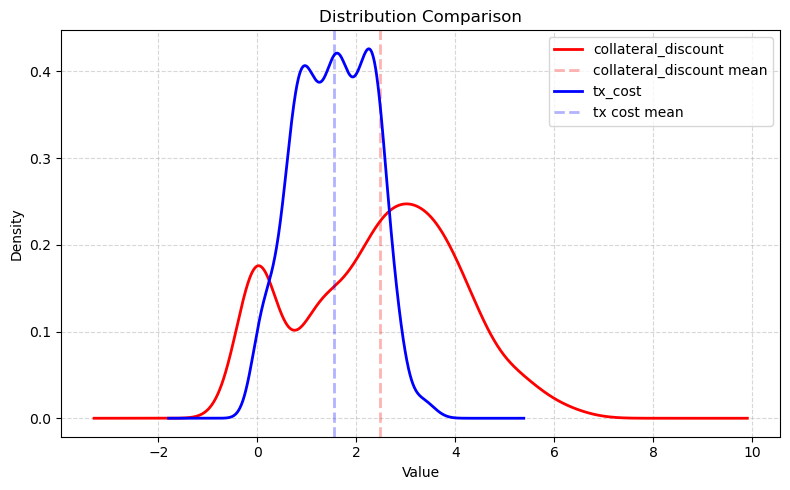

In [463]:

plt.figure(figsize=(8, 5))

x = df_usdc['collateral_discount'].clip(lower=1)  
xlog = np.log10(x)
xlog.plot(kind="kde", label='collateral_discount', color = 'red', linewidth=2)

mean_val_neg = xlog.mean()
plt.axvline(mean_val_neg, color='red', linestyle='--', linewidth=2, alpha = 0.3,  label='collateral_discount mean')


y = df_usdc['tx_cost_usd'].clip(lower=1)  
ylog = np.log10(y)
ylog.plot(kind="kde", label='tx_cost', color = 'blue', linewidth=2)

mean_val_pos = ylog.mean()
plt.axvline(mean_val_pos, color='blue', linestyle='--', linewidth=2, alpha = 0.3, label='tx cost mean')

plt.title("Distribution Comparison")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

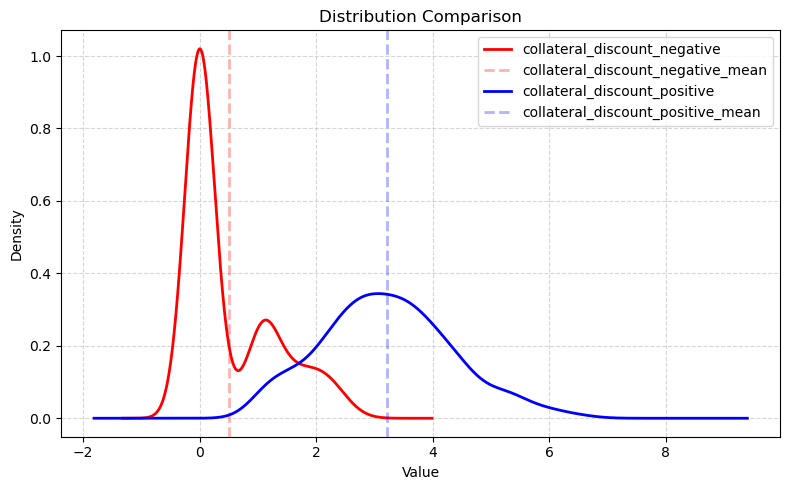

In [308]:

plt.figure(figsize=(8, 5))

x = df_usdc_liq_neg['collateral_discount'].clip(lower=1)  
xlog = np.log10(x)
xlog.plot(kind="kde", label='collateral_discount_negative', color = 'red', linewidth=2)

mean_val_neg = xlog.mean()
plt.axvline(mean_val_neg, color='red', linestyle='--', linewidth=2, alpha = 0.3,  label='collateral_discount_negative_mean')


y = df_usdc_liq_pos['collateral_discount'].clip(lower=1)  
ylog = np.log10(y)
ylog.plot(kind="kde", label='collateral_discount_positive', color = 'blue', linewidth=2)

mean_val_pos = ylog.mean()
plt.axvline(mean_val_pos, color='blue', linestyle='--', linewidth=2, alpha = 0.3, label='collateral_discount_positive_mean')

plt.title("Distribution Comparison")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

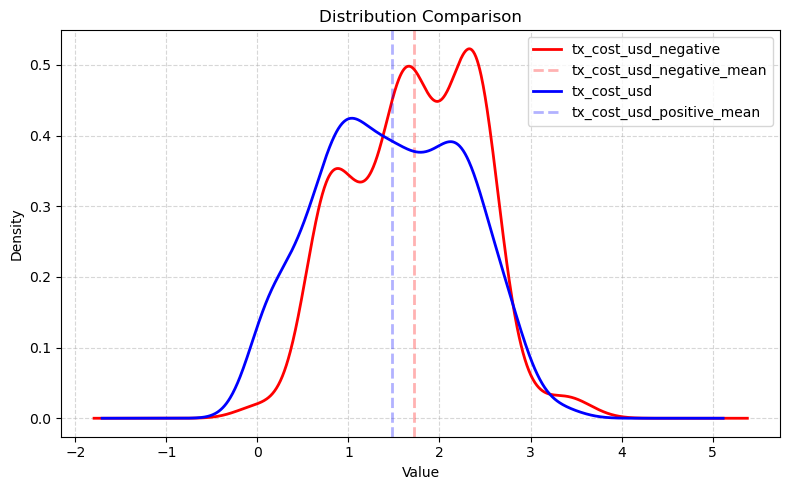

In [309]:
plt.figure(figsize=(8, 5))

x = df_usdc_liq_neg['tx_cost_usd'].clip(lower=1)  
xlog = np.log10(x)
xlog.plot(kind="kde", label='tx_cost_usd_negative', color = 'red', linewidth=2)

mean_val_neg = xlog.mean()
plt.axvline(mean_val_neg, color='red', linestyle='--', linewidth=2, alpha = 0.3,  label='tx_cost_usd_negative_mean')


y = df_usdc_liq_pos['tx_cost_usd'].clip(lower=1)  
ylog = np.log10(y)
ylog.plot(kind="kde", label='tx_cost_usd', color = 'blue', linewidth=2)

mean_val_pos = ylog.mean()
plt.axvline(mean_val_pos, color='blue', linestyle='--', linewidth=2, alpha = 0.3, label='tx_cost_usd_positive_mean')

plt.title("Distribution Comparison")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [321]:
# Example data
df_usdc['profit_is_pos'] = np.where(df_usdc['liq_net_profit_usd']>0, 1, 0)

# 1️⃣ Define bins and labels for col_B
#bins = [0, 100, 500, float('inf')]
#labels = ['0-100', '100-500', '500+']

bins = [0, 100, 300, 1000, float('inf')]
labels = ['0-100', '100-300', '300-1000', '1000+']

df_usdc["collateral_cat"] = pd.cut(df_usdc["collateral"], bins=bins, labels=labels, right=True)

# 2️⃣ Group by the new categories and calculate % of ones in col_A
result_1 = (
    df_usdc.groupby("collateral_cat")["profit_is_pos"]
      .mean()                # mean of 0/1 = proportion of 1s
      .mul(100)              # convert to percentage
      .reset_index(name="percent_of_profitable liquidations")
)

print(result_1)


  collateral_cat  percent_of_profitable liquidations
0          0-100                            0.675676
1        100-300                           52.380952
2       300-1000                           71.698113
3          1000+                           97.029703


C:\Users\aminm\AppData\Local\Temp\ipykernel_19784\1715852868.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_usdc.groupby("collateral_cat")["profit_is_pos"]


# counterfactual analysis

### description of the counterfactual analysis
- in the current format:
    - 100% of collateral is liquidated
    - collateral goes to the protocol entirely and later on liquidator gets the discounted collateral with a discount rate around 11%
    - protocol also charge 5% of the collateral from the original value as the liquidation penalty
    - if anything left, it would go to the liquidatee

In [323]:
df_usdc.columns

Index(['Unnamed: 0.1', 'Unnamed: 0_x', 'amount', 'amountUSD', 'blockNumber',
       'gasLimit', 'gasPrice', 'gasUsed', 'hash', 'id_x', 'logIndex', 'nonce',
       'positions', 'profitUSD', 'timestamp', 'asset_decimals', 'asset_id',
       'asset_symbol', 'liquidatee_id', 'liquidator_id', 'market_id',
       'positions_before', 'datetime_utc', 'month_end', 'month_end_str',
       'id_y', 'market_name', 'LINK', 'wstETH', 'cbBTC', 'COMP', 'WBTC',
       'WETH', 'UNI', 'tBTC', 'Unnamed: 0_y', 'LINK_usd', 'wstETH_usd',
       'cbBTC_usd', 'COMP_usd', 'WBTC_usd', 'WETH_usd', 'UNI_usd', 'tBTC_usd',
       'collateral', 'LOAN', 'LTV', 'collateral_count', 'profit_perc',
       'profit_USD', 'date', 'WETH_change', 'tx_cost_eth', 'tx_cost_usd',
       'bad_loan', 'store_front_pricefactor', 'COMP_lf', 'LINK_lf', 'UNI_lf',
       'WBTC_lf', 'WETH_lf', 'cbBTC_lf', 'tBTC_lf', 'wstETH_lf', '1',
       'collateral_discount', 'liq_net_profit_usd', 'remaining',
       'profit_is_pos', 'collateral_cat'],


In [322]:
df_usdc['LTV'].describe()

count    790.000000
mean       0.900677
std        0.071132
min        0.695405
25%        0.872621
50%        0.894924
75%        0.906929
max        1.369629
Name: LTV, dtype: float64

In [328]:
count = 0
for i in range(len(df_usdc)):
    if df_usdc.iloc[i]['LTV'] < 0.92:
        value = df_usdc.iloc[i]['collateral'] - 0.5*df_usdc.iloc[i]['LOAN']*(1.05)
        if value < 0:
            count += 1
print(count)

0


## alternative approach
- create column "close_factor". it is 0.5 if LTV < 9.92, else 1
- create alternate_delta_L = loan * 0.5
- create alternate_L_2 = alternate_delta_L
- create alternate_collateral_seized: alternate_delta_L * 1.05
- create alternate_collateral_2 = collateral - alternate_collateral_seized
- create alternate_LTV = alternate_L_2 / alternate_collateral_2
- create alternate_collateral_siezed_perc = alternate_collateral_siezed/collateral
- create alternate_collateral_discount = alternate_collateral_siezed_perc * collateral_discount
- create alternate_profit = alternate_collateral_discount - tx_cost
- create alternate_remaining = alternate_collateral_2 - alternate_L_2

In [329]:
df_draft = df_usdc

In [330]:
df_usdc.to_csv('df_usdc.csv')

In [353]:
liq_threshold = 0.92
close_factor = 0.5
df_usdc['close_factor'] = np.where(df_usdc['LTV']<0.92, close_factor, 1)
df_usdc['alternate_delta_L'] = df_usdc['LOAN']*df_usdc['close_factor']
df_usdc['alternate_L_2'] = df_usdc['LOAN'] - df_usdc['alternate_delta_L']
df_usdc['alternate_collateral_siezed'] = np.where(df_usdc['close_factor'] == close_factor, df_usdc['alternate_delta_L']*1.05, df_usdc['collateral'])
df_usdc['alternate_collateral_2'] = df_usdc['collateral'] - df_usdc['alternate_collateral_siezed']
df_usdc['alternate_LTV'] = np.where(df_usdc['close_factor'] == close_factor, df_usdc['alternate_L_2'] /df_usdc['alternate_collateral_2'], 0)
df_usdc['alternate_collateral_siezed_perc'] = df_usdc['alternate_collateral_siezed']/ df_usdc['collateral']
df_usdc['alternate_collateral_discount'] = df_usdc['alternate_collateral_siezed_perc'] * df_usdc['collateral_discount']
df_usdc['alternate_liq_net_profit'] = df_usdc['alternate_collateral_discount'] - df_usdc['tx_cost_usd']
df_usdc['alternate_remaining'] = np.where(df_usdc['close_factor']  == close_factor, df_usdc['alternate_collateral_2'] - df_usdc['alternate_L_2'], df_usdc['remaining'])

## checks
1- check if anyone is above the LTV 0.9

2- check if any liquidator profit in negative that it was positive before

3- compare remainings

4- compare liquidators profits

In [354]:
# check 1
df_usdc[df_usdc['close_factor'] == close_factor]['alternate_LTV'].describe()

count    644.000000
mean       0.814716
std        0.054529
min        0.547639
25%        0.785620
50%        0.836423
75%        0.850141
max        0.888816
Name: alternate_LTV, dtype: float64

In [355]:
## check 2
losers = df_usdc[(df_usdc['alternate_liq_net_profit']<0)&(df_usdc['liq_net_profit_usd']>0)]
len(losers)

35

In [356]:
len(df_usdc[df_usdc['close_factor'] == close_factor])

644

In [357]:
len(losers) / len(df_usdc[df_usdc['close_factor'] == close_factor])

0.05434782608695652

In [361]:
losers[['LTV', 'collateral', 'alternate_collateral_siezed', 'alternate_collateral_siezed_perc', 'LOAN', 'tx_cost_usd', 'liq_net_profit_usd', 'alternate_liq_net_profit']]\
.sort_values(by=['collateral'], ascending = False).head(10)

,LTV,collateral,alternate_collateral_siezed,alternate_collateral_siezed_perc,LOAN,tx_cost_usd,liq_net_profit_usd,alternate_liq_net_profit
758,0.898941,47365.048916,22353.654594,0.471944,42578.389703,2572.272757,2401.057380,-225.139024
459,0.839866,20898.441559,9214.744686,0.440930,17551.894640,2408.047732,634.577710,-1066.463645
692,0.764153,8176.513548,3280.256617,0.401180,6248.107841,614.986719,817.936450,-40.126092
192,0.874742,7143.021991,3280.359944,0.459240,6248.304655,585.219428,258.170442,-197.901238
135,0.915954,6027.300655,2898.382569,0.480876,5520.728702,578.072729,54.793840,-273.742559
767,0.890778,4909.092753,2295.779786,0.467659,4372.913879,248.090344,271.750061,-4.982472
89,0.908050,4876.528265,2324.770036,0.476726,4428.133401,246.084714,265.950754,-1.983860
240,0.896854,3194.194637,1503.982031,0.470849,2864.727679,219.371730,116.018707,-61.453617
740,0.887098,1941.010700,903.979659,0.465726,1721.866018,137.150195,66.655928,-42.232331
732,0.804712,1886.330700,796.925051,0.422474,1517.952479,121.620109,162.154556,-1.732785


In [359]:
(losers['tx_cost_usd'] / losers['collateral_discount']).describe()

count    35.000000
mean      0.637866
std       0.158259
min       0.428580
25%       0.509261
50%       0.603109
75%       0.731274
max       0.991350
dtype: float64

In [360]:
winners = df_usdc[df_usdc['alternate_liq_net_profit']>0]
(winners['tx_cost_usd'] / winners['collateral_discount']).describe()

count    538.000000
mean       0.078238
std        0.130486
min        0.000002
25%        0.003599
50%        0.017571
75%        0.092840
max        0.917319
dtype: float64

In [484]:
winners['liq_net_profit_usd'].describe()

count    5.380000e+02
mean     5.187680e+04
std      2.747859e+05
min      1.034639e+00
25%      3.211949e+02
50%      1.600998e+03
75%      9.930574e+03
max      3.961663e+06
Name: liq_net_profit_usd, dtype: float64

In [468]:
len(df_usdc[df_usdc['LTV']<0.92])/len(df_usdc)

0.8151898734177215

In [469]:
close_factor

0.5

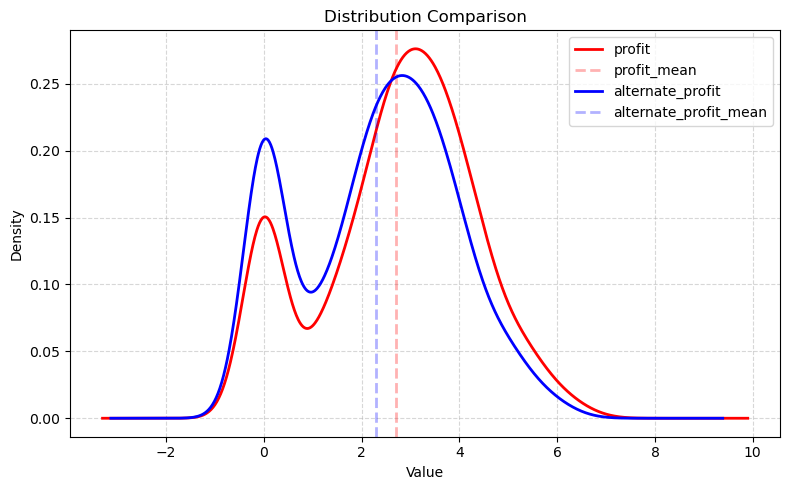

In [478]:
# check 3, 4
plt.figure(figsize=(8, 5))

x = df_usdc[df_usdc['close_factor'] == close_factor]['liq_net_profit_usd'].clip(lower=1)  
xlog = np.log10(x)
xlog.plot(kind="kde", label='profit', color = 'red', linewidth=2)

mean_val_neg = xlog.mean()
plt.axvline(mean_val_neg, color='red', linestyle='--', linewidth=2, alpha = 0.3,  label='profit_mean')


y = df_usdc[df_usdc['close_factor'] == close_factor]['alternate_liq_net_profit'].clip(lower=1)  
ylog = np.log10(y)
ylog.plot(kind="kde", label='alternate_profit', color = 'blue', linewidth=2)

mean_val_pos = ylog.mean()
plt.axvline(mean_val_pos, color='blue', linestyle='--', linewidth=2, alpha = 0.3, label='alternate_profit_mean')

plt.title("Distribution Comparison")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


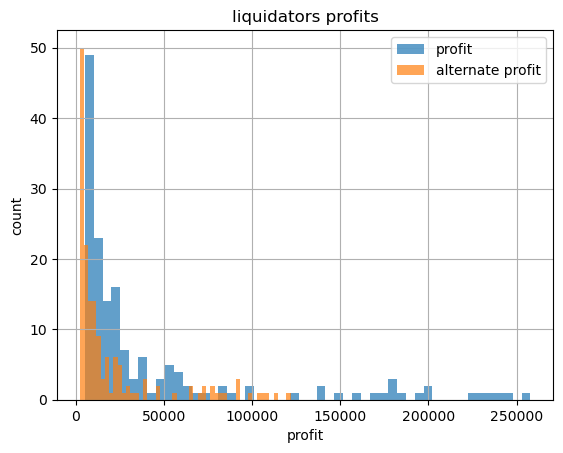

In [509]:
x = df_usdc[(df_usdc['close_factor'] == close_factor)&(df_usdc['liq_net_profit_usd'] > 5000)]#['liq_net_profit_usd']
uplimit = np.quantile(x['collateral_discount'],0.9)
xx = x[x['collateral_discount']<uplimit]
xx['liq_net_profit_usd'].hist(bins = 50, label = 'profit', alpha = 0.7)
xx['alternate_liq_net_profit'].hist(bins = 50, label = 'alternate profit', alpha = 0.7)
plt.legend()
plt.xlabel('profit')
plt.ylabel('count')
plt.title('liquidators profits')
plt.show()

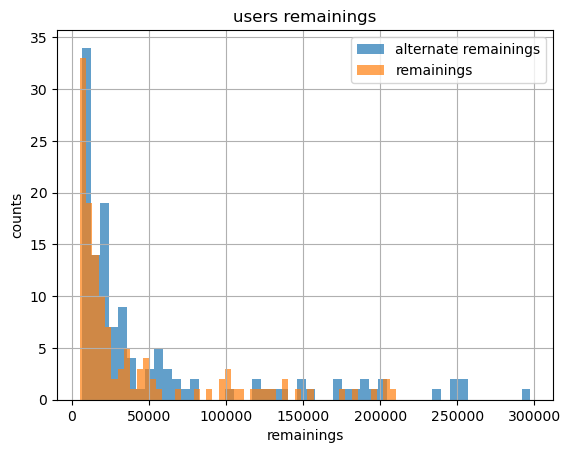

In [510]:
x = df_usdc[(df_usdc['close_factor'] == close_factor)&(df_usdc['remaining'] > 5000)]#['liq_net_profit_usd']
uplimit = np.quantile(x['collateral_discount'],0.9)
xx = x[x['collateral_discount']<uplimit]
xx['alternate_remaining'].hist(bins = 50, label = 'alternate remainings', alpha = 0.7)
xx['remaining'].hist(bins = 50, label = 'remainings', alpha = 0.7)
plt.legend()
plt.xlabel('remainings')
plt.ylabel('counts')
plt.title('users remainings')
plt.show()

In [487]:
df_usdc[df_usdc['close_factor'] == close_factor]['remaining'].mean() - df_usdc[df_usdc['close_factor'] == close_factor]['alternate_remaining'].mean()

np.float64(-10871.57957956411)

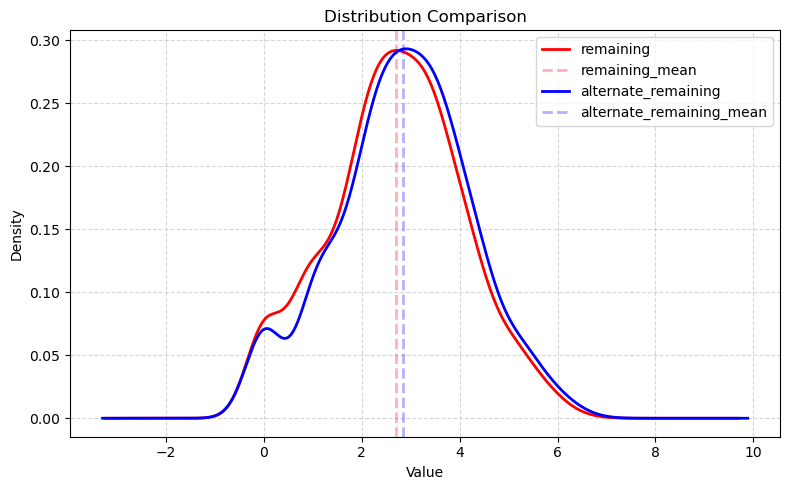

In [489]:
# check 3, 4
plt.figure(figsize=(8, 5))

x = df_usdc[df_usdc['close_factor'] == close_factor]['remaining'].clip(lower=1)  
xlog = np.log10(x)
xlog.plot(kind="kde", label='remaining', color = 'red', linewidth=2)

mean_val_neg = xlog.mean()
plt.axvline(mean_val_neg, color='red', linestyle='--', linewidth=2, alpha = 0.3,  label='remaining_mean')


y = df_usdc[df_usdc['close_factor'] == close_factor]['alternate_remaining'].clip(lower=1)  
ylog = np.log10(y)
ylog.plot(kind="kde", label='alternate_remaining', color = 'blue', linewidth=2)

mean_val_pos = ylog.mean()
plt.axvline(mean_val_pos, color='blue', linestyle='--', linewidth=2, alpha = 0.3, label='alternate_remaining_mean')

plt.title("Distribution Comparison")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [372]:
df_usdc[df_usdc['close_factor'] == close_factor]['remaining'].describe()

count    6.440000e+02
mean     2.560556e+04
std      1.493594e+05
min      3.500775e-07
25%      6.747097e+01
50%      5.180012e+02
75%      3.812883e+03
max      2.892752e+06
Name: remaining, dtype: float64

In [373]:
df_usdc[df_usdc['close_factor'] == close_factor]['alternate_remaining'].describe()

count    6.440000e+02
mean     3.647714e+04
std      2.110782e+05
min      6.418140e-07
25%      9.870427e+01
50%      7.103270e+02
75%      5.367967e+03
max      3.888286e+06
Name: alternate_remaining, dtype: float64

In [376]:
(df_usdc[df_usdc['close_factor'] == close_factor]['alternate_remaining'] - df_usdc[df_usdc['close_factor'] == close_factor]['remaining']).describe()

count    6.440000e+02
mean     1.087158e+04
std      6.394033e+04
min      2.683407e-07
25%      2.941764e+01
50%      2.146138e+02
75%      1.561942e+03
max      9.955337e+05
dtype: float64

In [378]:
df_usdc.to_csv('df_usdc_with_counterfactual.csv')